<a href="https://colab.research.google.com/github/Arup3201/SmartFlow-Traffic-Detector/blob/main/notebooks/traffic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
from google.colab import files
import zipfile
import glob
import pandas as pd
import plotly.express as px
import random
import numpy as np
from PIL import Image
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
import matplotlib.pyplot as plt

**Steps**:
1. Download and Import Images.
2. Build input pipeline to the model.
3. Seperate train, val and test.
4. Build the model.
5. Train the model.
6. Visualize training progress.
7. Test some images using the model.
8. Check the errors and inspect the reason.
9. Re-iterate the loop keeping the improvements in mind.

**Download the dataset from kaggle**

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arup7365","key":"73f0249bfd2f55df1abfaf3caecd0965"}'}

In [6]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d arup7365/traffic-classification-dataset

100% 976M/980M [00:35<00:00, 26.1MB/s]
100% 980M/980M [00:35<00:00, 29.1MB/s]


In [8]:
with zipfile.ZipFile("traffic-classification-dataset.zip", 'r') as zip_ref:
  zip_ref.extractall()

In [9]:
!rm traffic-classification-dataset.zip

**Inspect the dataset**

In [40]:
def get_examples(directory):
  examples = []

  for f in glob.glob(directory+"/"+"*.jpg"):
    examples.append(f)

  return examples

In [12]:
# Datasets path
dataset_dir = "traffic-detection-dataset"

# Images path of each class
cars_dir = "traffic-detection-dataset/car"
buses_dir = "traffic-detection-dataset/bus"
motorbikes_dir = "traffic-detection-dataset/motorbike"
trucks_dir = "traffic-detection-dataset/truck"
pedestrians_dir = "traffic-detection-dataset/pedestrian"

In [41]:
car_examples = get_examples(cars_dir)
bus_examples = get_examples(buses_dir)
motorbike_examples = get_examples(motorbikes_dir)
truck_examples = get_examples(trucks_dir)
pedestrian_examples = get_examples(pedestrians_dir)

In [42]:
counts = [len(car_examples), len(bus_examples), len(motorbike_examples), len(truck_examples),
          len(pedestrian_examples)]
categories = ["car", "bus", "motorbike", "truck", "pedestrian"]

df_counts = pd.DataFrame({"Category": categories, "Count": counts})
df_counts.head()

,Category,Count
0,car,17809
1,bus,799
2,motorbike,2300
3,truck,1430
4,pedestrian,9231


In [43]:
# Plot the diagram to show the counts of each class
fig = px.bar(df_counts, x='Count', y='Category', orientation='h')
fig.show()

**Sampling of the data**

In [44]:
# Taking 200 examples from each class
def get_samples(examples, nums=200):
  samples = random.sample(examples, nums)

  return samples

In [45]:
car_samples = get_samples(car_examples)
bus_samples = get_samples(bus_examples)
truck_samples = get_samples(truck_examples)
motorbike_samples = get_samples(motorbike_examples)
pedestrian_samples = get_samples(pedestrian_examples)

In [46]:
car_cats = np.repeat('car', len(car_samples))
bus_cats = np.repeat('bus', len(bus_samples))
truck_cats = np.repeat('truck', len(truck_samples))
motorbike_cats = np.repeat('motorbike', len(motorbike_samples))
pedestrian_cats = np.repeat('pedestrian', len(pedestrian_samples))

In [47]:
df_samples = pd.DataFrame({'Example': np.concatenate([car_samples, bus_samples, truck_samples,
                                                      motorbike_samples, pedestrian_samples]),
                           'Category': np.concatenate([car_cats, bus_cats, truck_cats, motorbike_cats,
                                                       pedestrian_cats])})
df_samples.head()

,Example,Category
0,traffic-detection-dataset/car/GGPT5BF3HM86.jpg,car
1,traffic-detection-dataset/car/ON95QHHY0GFH.jpg,car
2,traffic-detection-dataset/car/SQF0R1KN0ZRY.jpg,car
3,traffic-detection-dataset/car/TPVKD5TRPN9P.jpg,car
4,traffic-detection-dataset/car/CNA2U5899433.jpg,car


In [48]:
df_samples.shape

(1000, 2)

In [49]:
# Shuffle the dataset so that same classes do not come together always
df_samples = df_samples.sample(frac=1).reset_index(drop=True)

In [50]:
df_samples['Category'].unique()

array(['truck', 'car', 'pedestrian', 'bus', 'motorbike'], dtype=object)

**Prepare dataset for model training and testing**

In [55]:
# Get the features from each image using the path
IMG_DIMS = (128, 64)
BINS = 9
PIXELS_PER_CELL = (8, 8)
CELLS_PER_BLOCK = (2, 2)
CHANNEL_AXIS = -1

mapping = {"car": 0, "bus": 1, "truck": 2, "motorbike": 3, "pedestrian": 4}

def preprocess(x):
  path = x[0]
  cat = x[1]

  img = Image.open(path)
  img = img.resize(IMG_DIMS)

  features = hog(img, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK,
                 channel_axis=CHANNEL_AXIS)

  encoding = mapping[cat]

  return pd.Series([*features.tolist(), encoding])

In [57]:
data = df_samples.apply(preprocess, axis=1, result_type='expand')

In [58]:
data.shape

(1000, 3781)

**Split dataset into train, val and test**

In [59]:
X = df_samples.iloc[:, :-1]
y = df_samples.iloc[:, -1]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [71]:
X_train.shape, X_test.shape

((900, 1), (100, 1))

In [72]:
y_train.shape, y_test.shape

((900,), (100,))

**Model Development**

In [69]:
svc = SVC(kernel="rbf", gamma=0.001)

Text(0.5, 1.0, 'Learning Curve for SVC')

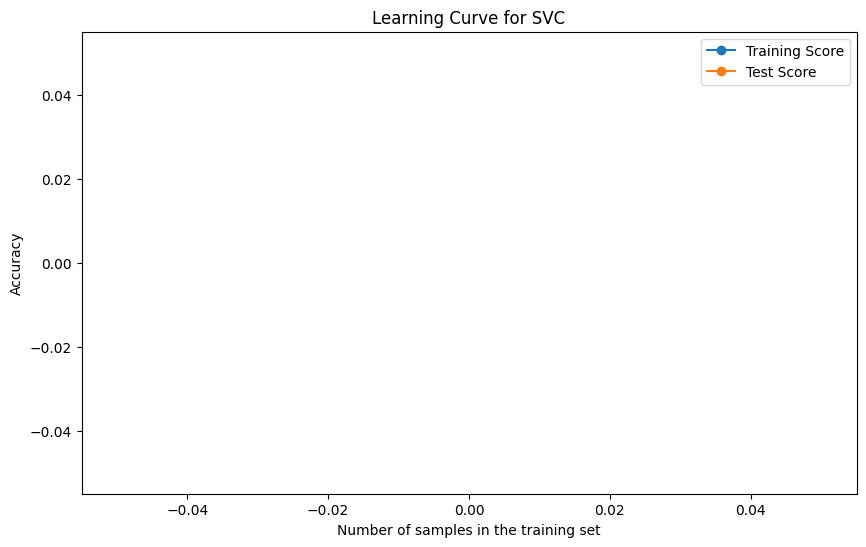

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.1, random_state=42),
    "score_type": 'both',
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(svc, **params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {svc.__class__.__name__}")